In [4]:
from pyfmi import load_fmu
import os 
import sys
import numpy as np
import pandas as pd
from pylab import *
from time import sleep
import seaborn as sn
from ../ddqn/environment.py import *
import calendar 
from datetime import timedelta, date
import logging
import math
import gym
from gym import spaces
from gym.utils import seeding
import gc


import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam



%matplotlib inline

plt.rcParams["figure.figsize"] = (15,8)

print(__doc__)

SyntaxError: invalid syntax (<ipython-input-4-ec611421b9b5>, line 9)

In [2]:
logger = logging.getLogger(__name__)
"""
EnergyPlus FMU model for co-simulation.
"""

class EP(gym.Env):
    
    reward_range = (-np.inf, np.inf)
    action_space = None
    observation_space = None
    
    def __init__(self, 
                 energy_plus_file,
                 state_size,
                 action_space,
                 solar_panel_area=50,
                 solar_panel_percent_active=0.9,
                 solar_panel_efficiency=0.9,
                 inverter_efficiency=0.9,
                 battery_discharge_efficiency=0.9,
                 battery_charge_efficiency=0.9,
                 battery_capacity=5000,
                 simulation_length=10):
        
        self.model = load_fmu(energy_plus_file, 
                              log_file_name='log_file.txt',
                              kind='auto')
        
        
        self.sim_duration = 86400
        self.numSteps = 144
        self.opts = self.model.simulate_options()
        self.opts['ncp'] = self.numSteps
        
        self.battery = Battery(capacity=battery_capacity,
                          charge_efficiency=battery_charge_efficiency,
                          discharge_efficiency=battery_discharge_efficiency)
        self.solar = SolarPanel(area=solar_panel_area,
                           f_active=solar_panel_percent_active,
                           eta_cell=solar_panel_efficiency,
                           eta_inv=inverter_efficiency)
        self._seed()
        self.action_space = action_space
        self.state = None
        self.state_size = state_size
        self.observation_space = None
        self.date =  datetime.date(2017, 1, 1)
        self.counter = 0
        self.store = pd.DataFrame({})
        self.time = self.model.time
        

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    
    def _step(self, action):
#         assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
        state = self.state
        
        start_time = self.counter * self.sim_duration
        final_time = (self.counter + 1) * self.sim_duration
        
        t = np.linspace(start_time,
                        final_time,
                        self.numSteps + 1, 
                        dtype=np.int64)



        battery_action = action_space[action] # replace with action 
        battery_flag = self.battery.step(battery_action)

#         avail_manager_action = action[:, 1]  # skipping the HVAC control for now
        avail_manager_action = np.random.randint(1, 2, 145)
        
        ut = np.transpose(np.vstack((t, np.repeat(avail_manager_action, 1))))
        input_object = ('Q', ut)

        res = self.model.simulate(start_time=start_time, 
                             final_time=final_time,
                             input=input_object,
                             options=self.opts)
        self.time = self.model.time


        df = pd.DataFrame({})
        for key in self.model.get_model_variables().keys():
            df[key] = res[key]
            
        df['managerAction'] = avail_manager_action 
        
        
        df[self.battery.id] = self.battery.get_history()['state'][self.counter * self.numSteps: 
                                                        (self.counter + 1) * self.numSteps + 1]
        df['charge_discharge'] = self.battery.get_history()['current'][self.counter * self.numSteps: 
                                                        (self.counter + 1) * self.numSteps + 1]
        df['solar_generation'] = self.solar.step(res['directSolarRad'])
        df['substation_electiricty'] = res['totalDemand'] - df['charge_discharge'] - df['solar_generation']
        df.index = pd.DatetimeIndex(pd.date_range(str(self.date.month) + '/' + str(self.date.day) + '/' +
                                                  str(self.date.year), periods=145, freq='10min'))

        self.store = self.store.append(df)
        self.date = self.date + datetime.timedelta(days=1)
        
        self.state = df[['outdoorDbTemp', 'solar_generation', 
                         self.battery.id, 'totalDemand']]
        self.state['weekday'] = self.date.weekday()
        self.state['month'] = self.date.month
        
        #updating the counter
        self.counter += 1
        
        reward = - np.clip(df['substation_electiricty'], -1, 1)
        done = np.zeros(reward.shape[0]) > 1
        done[-1] = True
        
        return self.state.values, reward, done
    
    def _reset(self):
        self.state = np.random.uniform(low=-0.05, high=0.05,
                                      size=(145, self.state_size))
        return np.array(self.state)
    
    def _close(self):
        self.model.terminate()
        gc.collect()


    
    
class Space(object):
    """Defines the observation and action spaces, so you can write generic
    code that applies to any Env. For example, you can choose a random
    action.
    """

    def sample(self):
        """
        Uniformly randomly sample a random element of this space
        """
        self.state = np.random.uniform(low=-0.05, high=0.05,
                                      size=(145, 4))
        return np.array(self.state)

    def contains(self, x):
        """
        Return boolean specifying if x is a valid
        member of this space
        """
        return True

    def to_jsonable(self, sample_n):
        """Convert a batch of samples from this space to a JSONable data type."""
        # By default, assume identity is JSONable
        return sample_n

    def from_jsonable(self, sample_n):
        """Convert a JSONable data type to a batch of samples from this space."""
        # By default, assume identity is JSONable
        return sample_n

    
    
class DDQNAgent(object):
    """
    Deep Q-Learning agent implementation.
    """
    
    
    def __init__(self, state_size, action_size, 
                 memory_lenght, discount=0.99, epsilon=1):
        
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=memory_lenght)
        self.gamma = discount
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.learning_rate = 0.001
        self.network = self._build_network()
        self.target_network = self._build_network()
        self.update_target_network()
        
    
    def _build_network(self):
        """
        build neural network for Deep Q-learning model.
        """
        
        network = Sequential()
        network.add(Dense(256, input_dim=self.state_size,
                         activation='relu'))
        network.add(Dense(256, activation='relu'))
        network.add(Dense(256, activation='relu'))
        network.add(Dense(64, activation='relu'))
        network.add(Dense(self.action_size, activation='linear'))
        network.compile(loss='mse',
                       optimizer=Adam(lr=self.learning_rate))
        return network

    def update_target_network(self):
        # copy weights from model to target_model
        self.target_network.set_weights(self.network.get_weights())
        
    def remember(self, state, action, reward, next_state, done):
        for mem in zip(state, action, reward, next_state, done):
            self.memory.append(mem)

    
    def act(self, states):
        actions = []
        for state in states:
            if np.random.rand() <= self.epsilon:
                actions.append(random.randrange(self.action_size))
            action_value = self.network.predict(state.reshape((1, self.state_size)))
            actions.append(np.argmax(action_value))
        return actions
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.network.predict(state.reshape((1, self.state_size)))
            if done:
                target[0][action] = reward
            else:
                a = self.network.predict(next_state.reshape((1, self.state_size)))[0]
                t = self.target_network.predict(next_state.reshape((1, self.state_size)))[0]
                target[0][action] = reward + self.gamma * t[np.argmax(a)]
            self.network.fit(state.reshape((1,self.state_size)), target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        
    def load(self, name):
        self.network.load_weights(name)

    def save(self, name):
        self.network.save_weights(name)  
        
def pplot(ax,y, colors=['b']):
    x = range(len(y))
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            line.set_ydata(y)
    else:
        for color in colors:
            ax.plot(x, y, color)
    fig.canvas.draw()
    
    
def check_path(path):
    if path != os.getcwd():
        os.chdir(path)
    

In [4]:
if __name__ == "__main__":
    
#     %matplotlib notebook
    path = '/home/mfc/Projects/research/small_office/'
    check_path(path)
    state_size = 6
    action_size = 4
    action_space = np.linspace(-5000, 5000, 4)

    env = EP('small_office.fmu', state_size=state_size,
             battery_capacity=10000, action_space=action_space)

    agent = DDQNAgent(state_size, action_size, 2000, 0.99)
    done = False
    batch_size = 32
    load_weights = False
    episodes = 50
    reward_list = []
    total_reward = 0
    
    if 'save' not in os.listdir('.'):
        os.mkdir('./save/')
    
    if load_weights:
        agent.load('./save/ddqn.h5')
        
        
    for e in range(episodes):
        check_path(path)
        states = env.reset()
        states = np.reshape(states, [states.shape[0], state_size])
        for time in range(50):
            actions = agent.act(states)
            next_state, reward, done = env.step(actions)
            next_state = np.reshape(next_state, [next_state.shape[0], state_size])
            agent.remember(states, actions, reward, next_state, done)
            states = next_state
            total_reward += reward.sum()
            reward_list.append(total_reward)
#             if done:
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, episodes,time, agent.epsilon))
#                 break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        if e % 10 == 0:
            agent.save("./save/ddqn.h5")
            
#         fig,ax = plt.subplots(1,1, figsize=(10, 8))
#         ax.set_xlabel('episode')
#         ax.set_ylabel('reward')
#         ax.set_xlim(0,e + 5)
#         ax.set_ylim(-1000, 1000)
#         pplot(ax, reward_list, ['b'])
            


Simulation interval    : 0 - 86400.0 seconds.
Elapsed simulation time: 0.023243188858 seconds.
episode: 0/50, score: 0, e: 1


/home/mfc/.virtualenvs/research/lib/python2.7/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mfc/.virtualenvs/research/lib/python2.7/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Simulation interval    : 86400 - 172800.0 seconds.
Elapsed simulation time: 0.0211291313171 seconds.
episode: 0/50, score: 1, e: 1
Simulation interval    : 172800 - 259200.0 seconds.
Elapsed simulation time: 0.0206198692322 seconds.
episode: 0/50, score: 2, e: 1
Simulation interval    : 259200 - 345600.0 seconds.
Elapsed simulation time: 0.0237619876862 seconds.
episode: 0/50, score: 3, e: 1
Simulation interval    : 345600 - 432000.0 seconds.
Elapsed simulation time: 0.0237059593201 seconds.
episode: 0/50, score: 4, e: 1
Simulation interval    : 432000 - 518400.0 seconds.
Elapsed simulation time: 0.0211040973663 seconds.
episode: 0/50, score: 5, e: 1
Simulation interval    : 518400 - 604800.0 seconds.
Elapsed simulation time: 0.020800113678 seconds.
episode: 0/50, score: 6, e: 1
Simulation interval    : 604800 - 691200.0 seconds.
Elapsed simulation time: 0.0221359729767 seconds.
episode: 0/50, score: 7, e: 1
Simulation interval    : 691200 - 777600.0 seconds.
Elapsed simulation time: 0

IOError: Unable to create file (Unable to truncate a file which is already open)

In [ ]:
os.getcwd(

In [ ]:
ls

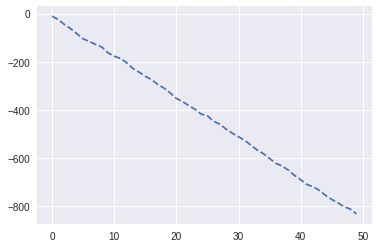

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(reward_list, '--')



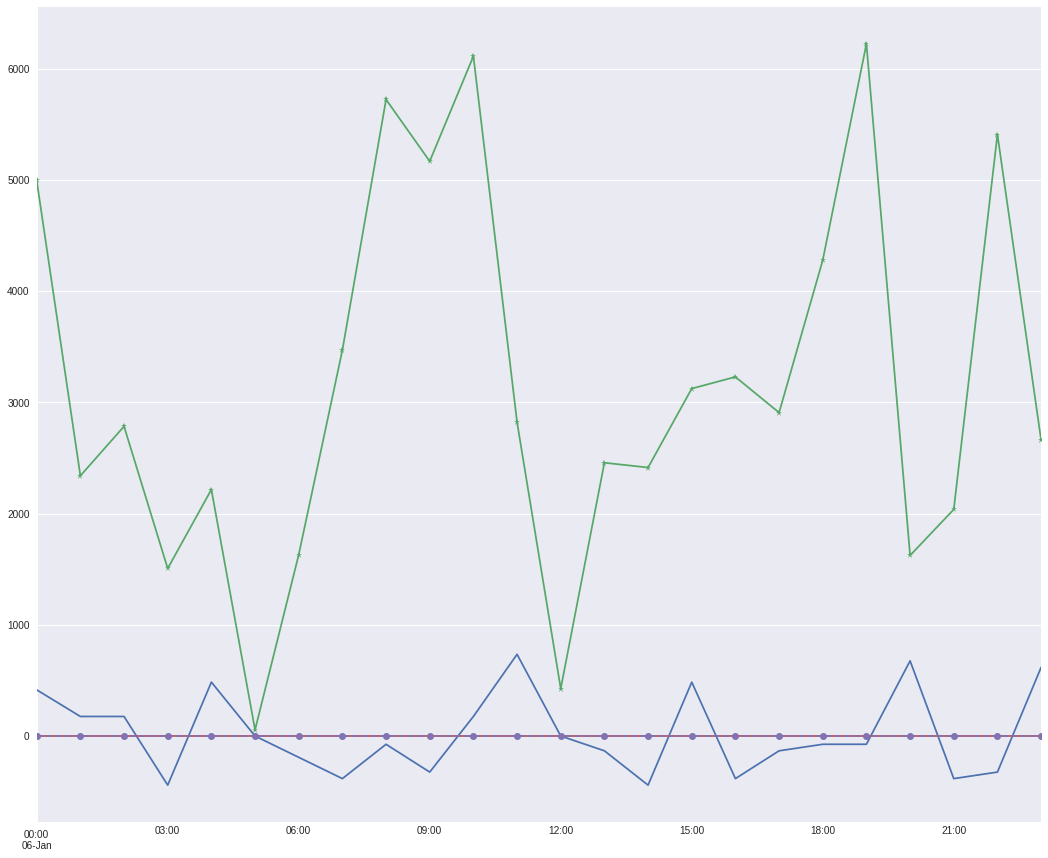

In [16]:
day = 5
env.store.substation_electiricty.resample('1H').mean()[day * 24: (day+1) * 24].plot(figsize=(18, 15))
env.store.battery_1.resample('1H').mean()[day * 24: (day+1) * 24].plot(style='-*')
env.store.totalDemand.resample('1H').mean()[day * 24: (day+1) * 24].plot(style='-')
env.store.solar_generation.resample('1H').mean()[day * 24: (day+1) * 24].plot(style='--o')

# env.store.totalDemand[:200].plot()
# env.store.solar_generation[:200].plot()

In [ ]:
env.store.plot(figsize=(20,20))

In [ ]:
a = pd.DataFrame(np.random.randn(10,2))

In [ ]:
plt.plot(reward_list)

In [ ]:
plt.imshow(agent.network.get_weights()[0])


In [ ]:
plt.imshow(agent.network.get_weights()[2])

In [ ]:
plt.imshow(agent.network.get_weights()[4])

In [ ]:
plt.imshow(agent.network.get_weights()[6])

In [ ]:
plt.imshow(agent.network.get_weights()[8])